In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator, interpolant
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import random
from keras.callbacks import EarlyStopping
import time
import optuna

c:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Definir a seed
seed = 43
seed2 = 14
seed3 = 42
np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed2)


In [4]:
import pandas as pd


def create_interpolation(file_path, decimal=','):

    # Carregar os dados do CSV
    data = pd.read_csv(file_path, decimal=decimal)
    
    # Configurar os eixos da malha
    N_rot = np.arange(2e4, 6e4, 1e3)  # De 20000 Hz a 60000 Hz, Shape: (40,)
    Mass = np.arange(3, 21.1, 0.1)   # De 3 a 21, Shape: (181,)
    Phi = data.values                # Valores da tabela, Shape: (40,181)
    
    # Linearizar a matriz Phi para criação da LUT
    phi_flat = Phi.ravel(order='F')
    
    # Criar a LUT usando interpolação b-spline
    lut = interpolant('name', 'bspline', [N_rot, Mass], phi_flat)
    
    return lut

# Caminho para o arquivo CSV
file_path = r"C:\Users\fabio\Downloads\tabela_phi.csv"

# Chamar a função e obter a LUT
interpolation = create_interpolation(file_path)


N_rot_example = 3e4  
Mass_example = 21  
result = interpolation([N_rot_example, Mass_example]) 

# Exibir o resultado
print(f"Interpolação para N_rot={N_rot_example}, Mass={Mass_example}: {result}")



Interpolação para N_rot=30000.0, Mass=21: -2.22029


In [5]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(4000, 5000)  # MPa
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value



class N_generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def N(self):
        while True:
            value = np.random.uniform(27e3, 5e4)  
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value

In [6]:


def ale():
  return np.random.uniform(4000, 5000)



p1_gen = P1Generator(seed)
N_gen = N_generator(seed)


def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3   # m²
    L_c = 2.0      # m
    alpha = 0.5   #  
    P_out = 5.0 
    C1 = 479.029  # Constante
    V_p = 2.0    # m³
    K_nu = 0.38   # kg / (kPa^0.5 s)
    phi = 1.5   # φ
    z = 0 if x[1] < P_out else np.sqrt(x[1]*1e3   - P_out*1e3)

    dmdt = (A1 / L_c) * ((phi * 4.5 - x[1]) *1e3)
    dPdt = ((C1**2/V_p) * (x[0] - alpha * K_nu * z )) 

    return dmdt, dPdt

stati = fsolve(Estacionario, [100, 105])

print(Estacionario(stati))


(np.float64(0.0), np.float64(0.0))


In [7]:
def Sistemas(x0, P1_value, interpolant_function, N_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p',2)
    start = time.time()

    #N = p[1]
    phi = interpolant_function(vertcat(p[1], x[0])) 
    
    

    # Constantes
    A1 = 2.6e-3          # m²
    L_c = 2.0            # m
    alpha = 0.5          # Constante Abertura da valvula
    P_out = 5.0          #  kPa
    C1 = 479.029         # Constante Velocidade do Som na Entrada do Compressor 
    V_p = 2.0            # m³
    K_nu = 0.38         # kg / (kBar^0.5 s)
    phi_value = 1.5      # 

    z = if_else(x[1] < P_out, 0, sqrt(x[1]*1000 - P_out*1000))

    rhs = vertcat(
        (A1 / L_c) * (1.5 * (p[0]/1000) - x[1] )*1000,    # Vazão Massica/ dt
        (C1**2 / V_p) * (x[0] - alpha * K_nu * sqrt(x[1]*1000 - P_out*1000))         # Pressão do Plenum / dt
    ) 

    ode = {'x': x, 'ode': rhs , 'p': p}
    F = integrator('F', 'cvodes', ode, {'tf': 60})

    #
    t_eval = np.linspace(0, 60, 360)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9

    #
    for i in range(len(t_eval)):
        param = [P1_value, N_value]
        res = F(x0=x0, p=param)
        x_next = res['xf'].full().flatten()
        sol[i] = x_next
        # Update initial state
        x0 = x_next

    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    
    return sol, P1_value,N_value, t_eval



In [8]:
def Loop(loops, stati):
    estados = []
    p1_total = []
    N_total = []
    t_eval_total = []

    for i in range(loops):
        if i == 0:

            x0 = stati  # Estado inicial
        else:
            x0 = estados[-1][-1]

        P1_v = p1_gen.P1()  # Geração aleatória de P1
        N_v = N_gen.N()
        sol, P1_aleatorio,aaaa, t_eval = Sistemas(x0, P1_v, interpolation,N_v)
        estados.append(sol)
        N_total.append(aaaa)
        p1_total.append(P1_aleatorio)
        
        # Concatenar tempo
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, N_total, t_total



CasADi - 2024-11-28 22:19:09 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


Tempo de execução: 0.2344834804534912 segundos
Tempo de execução: 0.12191891670227051 segundos
Tempo de execução: 0.11425161361694336 segundos
Tempo de execução: 0.10713315010070801 segundos
Tempo de execução: 0.09302330017089844 segundos
Tempo de execução: 0.09080767631530762 segundos
Tempo de execução: 0.11666131019592285 segundos
Tempo de execução: 0.1391000747680664 segundos
Tempo de execução: 0.09278178215026855 segundos
Tempo de execução: 0.07826471328735352 segundos
Tempo de execução: 0.0808115005493164 segundos
Tempo de execução: 0.09036374092102051 segundos
Tempo de execução: 0.08849930763244629 segundos
Tempo de execução: 0.07482194900512695 segundos
Tempo de execução: 0.0818791389465332 segundos
Tempo de execução: 0.09230279922485352 segundos
Tempo de execução: 0.09375262260437012 segundos
Tempo de execução: 0.07410383224487305 segundos
Tempo de execução: 0.06662344932556152 segundos
Tempo de execução: 0.07415032386779785 segundos
Tempo de execução: 0.07156181335449219 segun

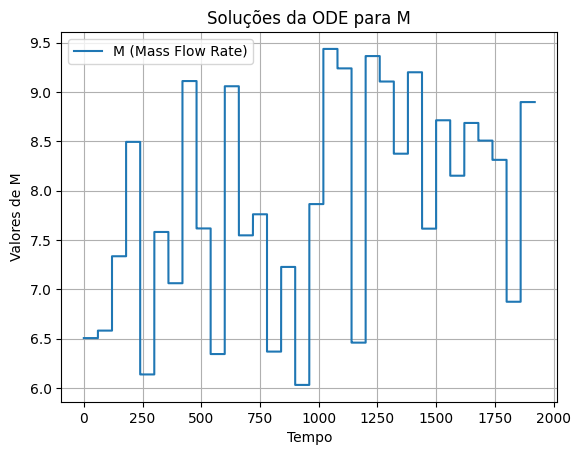

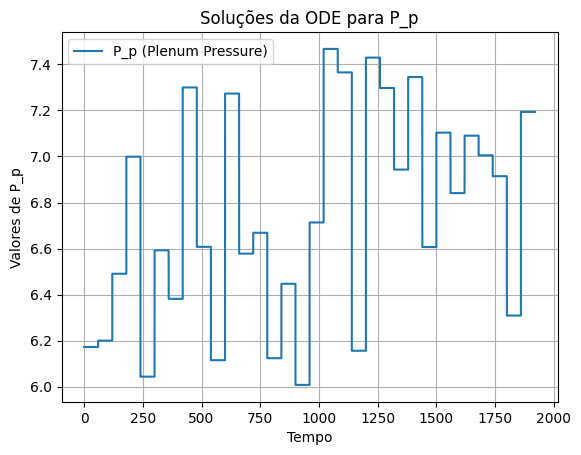

In [9]:

aaaa, PlotP1, PlotN, Plott = Loop(32, stati)
bbb = aaaa
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]

P_p_final = Ploty[:,1]



# Plotar os resultados

plt.figure()



plt.plot(Plott, Ploty[:, 0], label='M (Mass Flow Rate)')
plt.xlabel('Tempo')

plt.ylabel('Valores de M')
plt.title('Soluções da ODE para M')
plt.legend()
plt.grid(True)



plt.figure()
plt.plot(Plott, Ploty[:, 1], label='P_p (Plenum Pressure)')
plt.xlabel('Tempo')
plt.ylabel('Valores de P_p')
plt.title('Soluções da ODE para P_p')
plt.legend()
plt.grid(True)
plt.show()

In [10]:

# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
N_values = np.array(PlotN)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]

# Garantindo que as repetições sejam suficientes
repeated_P1 = np.repeat(P1_values, -(-len(M[:-1]) // len(P1_values)))[:len(M[:-1])]
repeated_N = np.repeat(N_values, -(-len(M[:-1]) // len(N_values)))[:len(M[:-1])]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], repeated_P1, repeated_N))
y = np.column_stack((M[1:], P_p[1:]))

split_index = len(X) // 2

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



In [11]:
# Normalização de dados para o intervalo [-1, 1]
def normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = 2 * (Mat_dados[:, i] - min_value) / (max_value - min_value) - 1
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = 2 * (Mat_dados[:] - min_value) / (max_value - min_value) - 1

    return result


# Desnormalização de dados do intervalo [-1, 1] para os valores originais
def des_normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] + 1) * (max_value - min_value) / 2 + min_value

    return result


In [12]:

X_test_ref = X_test
y_test_ref = y_test
X_train = normalize(X_train,X_train)
X_test =   normalize(X_test,X_test)
# 
y_train = normalize(y_train,y_train)
y_test =   normalize(y_test,y_test)


In [13]:

# Redimensionar as entradas para (batch_size, timesteps, features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Função de objetivo para Optuna
def objective(trial):
    # Hiperparâmetros a serem otimizados
    n_units = trial.suggest_int('n_units', 80, 100)
    dropout_rate = trial.suggest_float('dropout_rate', 0.001, 0.05)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Construção do modelo
    model = keras.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(n_units, return_sequences=False, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(2))

    # Configuração do otimizador
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    early_stopping = EarlyStopping(monitor='val_loss',
                                    patience=5,
                                    restore_best_weights=True)
    
    # Treinar o modelo
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=50,
                        batch_size=128,
                        verbose=0,
                        callbacks=[early_stopping])
    
    # Avaliar o modelo e retornar o valor da métrica que estamos otimizando
    val_loss = model.evaluate(X_test, y_test, verbose=0)

    return val_loss[0]


In [14]:



# Rodar a otimização com Optuna
study = optuna.create_study(direction='minimize')
study.optimize



[I 2024-11-28 22:19:13,848] A new study created in memory with name: no-name-f882c5e2-92d2-431c-8ae1-6534e40ea25d


<bound method Study.optimize of <optuna.study.study.Study object at 0x0000015734A701D0>>

In [15]:


study.optimize(objective, n_trials=10)


# Imprimir o melhor conjunto de hiperparâmetros
print(study.best_params)



c:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-11-28 22:19:42,358] Trial 0 finished with value: 0.011693690903484821 and parameters: {'n_units': 90, 'dropout_rate': 0.04248891469588843, 'learning_rate': 0.0005644362861533681}. Best is trial 0 with value: 0.011693690903484821.
[I 2024-11-28 22:20:16,905] Trial 1 finished with value: 0.013431061990559101 and parameters: {'n_units': 91, 'dropout_rate': 0.037284944588268615, 'learning_rate': 0.0071470208414286685}. Best is trial 0 with value: 0.011693690903484821.
[I 2024-11-28 22:21:37,135] Trial 2 finished with value: 0.011607480235397816 and parameters: {'n_units': 84, 'dropout_rate': 0.01666854974802949, 'learning_rate': 3.5833672330019424e-05}. Best 

{'n_units': 87, 'dropout_rate': 0.003008068213229641, 'learning_rate': 5.6257014240604674e-05}


C:\Users\fabio\AppData\Local\Temp\ipykernel_22016\1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

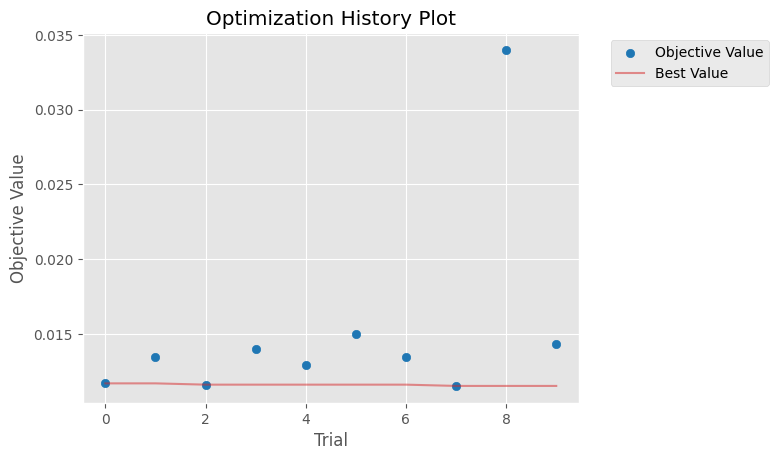

In [16]:
optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\fabio\AppData\Local\Temp\ipykernel_22016\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

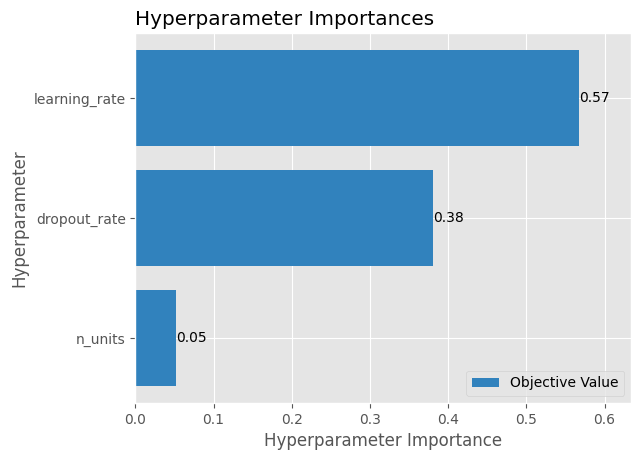

In [17]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [18]:
X_train.shape

(5759, 4, 1)

In [19]:
# Treinar o modelo final com os melhores parâmetros
best_params = study.best_params


# Criando o modelo sequencial
model = keras.Sequential([
    # Camada LSTM bidirecional com ativação 'tanh'
    layers.Bidirectional(layers.LSTM(best_params['n_units'], return_sequences=False, activation='tanh'), 
                         input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # Normalização de batch (opcional)
    #layers.BatchNormalization(),
    
    # Camada densa com ativação 'sigmoid' (opcional, dependendo do caso)
   # layers.Dense(best_params['n_units'], activation='sigmoid'),
    
    # Camada final de saída com 2 unidades e ativação 'linear' para regressão
    layers.Dense(2)

])

#model = keras.Sequential()
#odel.add(layers.Bidirectional(layers.LSTM(best_params['n_units'], return_sequences=False, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(best_params['n_units'], activation="sigmoid" ))
#model.add(layers.Dropout(best_params['dropout_rate']))
#model.add(layers.Dense(2))

optimizer = keras.optimizers.Adam(learning_rate=best_params['learning_rate'])



model.compile(optimizer=optimizer, loss="mse", metrics=["mae"],)



early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    
                    #validation_data=(X_test, y_test),
                    epochs=200,
                    batch_size=128,
                    verbose=2,
                    #callbacks=[early_stopping]
                    )



c:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
45/45 - 14s - 322ms/step - loss: 0.4045 - mae: 0.5250
Epoch 2/200
45/45 - 1s - 13ms/step - loss: 0.3528 - mae: 0.4873
Epoch 3/200
45/45 - 1s - 14ms/step - loss: 0.3037 - mae: 0.4490
Epoch 4/200
45/45 - 1s - 15ms/step - loss: 0.2561 - mae: 0.4088
Epoch 5/200
45/45 - 1s - 13ms/step - loss: 0.2100 - mae: 0.3646
Epoch 6/200
45/45 - 1s - 13ms/step - loss: 0.1673 - mae: 0.3191
Epoch 7/200
45/45 - 1s - 13ms/step - loss: 0.1304 - mae: 0.2818
Epoch 8/200
45/45 - 1s - 13ms/step - loss: 0.1008 - mae: 0.2466
Epoch 9/200
45/45 - 1s - 13ms/step - loss: 0.0777 - mae: 0.2139
Epoch 10/200
45/45 - 1s - 14ms/step - loss: 0.0596 - mae: 0.1888
Epoch 11/200
45/45 - 1s - 14ms/step - loss: 0.0457 - mae: 0.1658
Epoch 12/200
45/45 - 1s - 13ms/step - loss: 0.0352 - mae: 0.1461
Epoch 13/200
45/45 - 1s - 13ms/step - loss: 0.0278 - mae: 0.1293
Epoch 14/200
45/45 - 1s - 14ms/step - loss: 0.0226 - mae: 0.1163
Epoch 15/200
45/45 - 1s - 13ms/step - loss: 0.0190 - mae: 0.1059
Epoch 16/200
45/45 - 1s - 13ms/s

In [20]:
#75/75 - 1s - 13ms/step - loss: 8.6903e-04 - mae: 0.0104 - val_loss: 0.0235 - val_mae: 0.1405

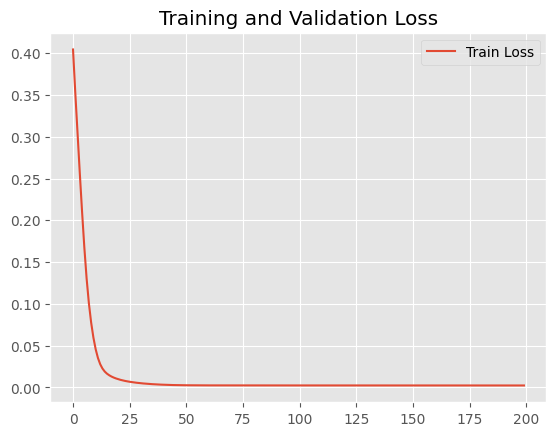

In [21]:

# Plotar a perda de trein
# amento e validação

plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Tempo de execução: 2.2373642921447754 segundos


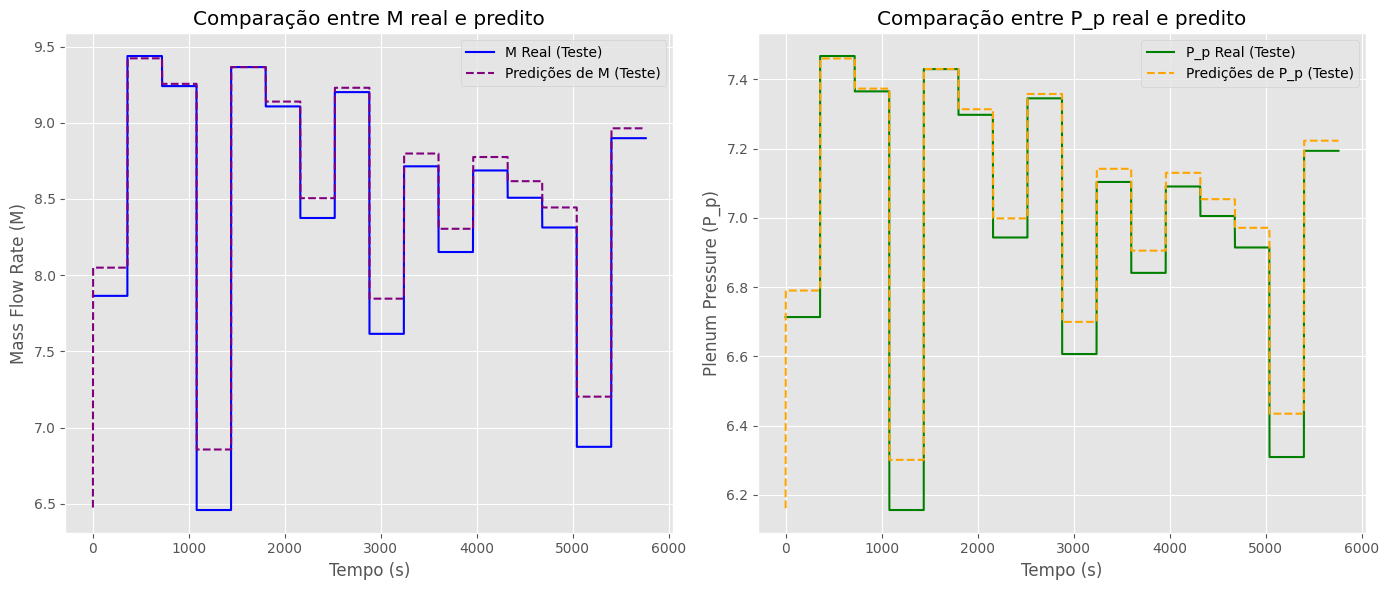

In [22]:
# Separar os dados de entrada (X_test) e as saídas reais (y_test)
rename_X = X_test.reshape(-1,4)  
rename_y = y_test.reshape(-1,2) # Saídas reais padronizadas (y_test)
#rename_X = des_normalize(rename_X,rename_X)



start = time.time()
y_test_pred = model.predict(rename_X)
end = time.time()
print(f"Tempo de execução: {end - start} segundos")


#
y_test_pred_des = des_normalize(y_test_ref, y_test_pred)
y_test_real_des = des_normalize(y_test_ref,rename_y)  # 

# 3. Separar as colunas de saídas reais (M e P_p)
M_real = y_test_real_des[:, 0]  # 
P_p_real = y_test_real_des[:, 1]  

# 4. Separar as colunas de predições (M e P_p preditos)
M_test_pred = y_test_pred_des[:, 0]  #
P_p_test_pred = y_test_pred_des[:, 1]  # 


t_eval_test = np.linspace(0, len(M_test_pred) - 1, len(M_test_pred))



plt.figure(figsize=(14, 6))

# Plot para M (Mass Flow Rate)
plt.subplot(1, 2, 1)
plt.plot(t_eval_test, M_real, label='M Real (Teste)', color='blue', linestyle='-')  # Saída real de M
plt.plot(t_eval_test, M_test_pred, label='Predições de M (Teste)', color='purple', linestyle='--')  # Predições de M
plt.xlabel('Tempo (s)')
plt.ylabel('Mass Flow Rate (M)')
plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.subplot(1, 2, 2)
plt.plot(t_eval_test, P_p_real, label='P_p Real (Teste)', color='green', linestyle='-')  # Saída real de P_p
plt.plot(t_eval_test, P_p_test_pred, label='Predições de P_p (Teste)', color='orange', linestyle='--')  # Predições de P_p
plt.xlabel('Tempo (s)')
plt.ylabel('Plenum Pressure (P_p)')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()


In [23]:
import tf2onnx
import onnx
import os 



In [24]:
from tensorflow.keras.saving import register_keras_serializable, load_model

@register_keras_serializable()
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

loaded_model = keras.saving.load_model(r'C:\Users\fabio\PycharmProjects\PRH-1\Greitzer_Model\model_plus_phi_2711.h5', custom_objects={'mse': mse})


In [25]:
onnx_model, _ = tf2onnx.convert.from_keras(model)


AttributeError: 'Sequential' object has no attribute 'output_names'